## Imports

In [ ]:
import joblib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    classification_report,
)


## Data Loading

In [ ]:
data = joblib.load("data_splits.pkl") ## Load the pre-processed data splits from the pickle file

#Extract the training, validation, and testing data
X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]

## Naive Bayes Class

In [ ]:
class NaiveBayes:
    def __init__(self, smoothing=1):
        self.smoothing = smoothing  # Laplace smoothing parameter
        self.class_probs = {} # Store probabilities of each class
        self.feature_probs = {}  # Store probabilities of features given a class

    def train(self, X, y):
        classes = np.unique(y)
        n_samples = len(y)
        self.y = y # Store y as an instance variable

        # Calculate class probabilities
        for cls in classes:
            self.class_probs[cls] = np.sum(y == cls) / n_samples
            self.feature_probs[cls] = {}

             # Calculate feature probabilities for each feature
            for feature_idx in range(X.shape[1]):
                feature_values = np.unique(X[:, feature_idx])
                self.feature_probs[cls][feature_idx] = {}

                for value in feature_values:
                    n_value_cls = np.sum((X[:, feature_idx] == value) & (y == cls))
                    n_cls = np.sum(y == cls)
                    self.feature_probs[cls][feature_idx][value] = (n_value_cls + self.smoothing) / (n_cls + self.smoothing * len(feature_values))

    def predict(self, X):
      #Predicts the class labels for the given data
        predictions = []
        for sample in X:
            class_scores = {} # store scores for each class
            for cls in self.class_probs:
                score = self.class_probs[cls] # start with prior probability of the class
                for feature_idx, value in enumerate(sample):
                    if value in self.feature_probs[cls][feature_idx]:
                        score *= self.feature_probs[cls][feature_idx][value] # Multiply by likelihood if feature seen
                    else:
                        # Handle unseen feature values using self.y
                        score *= self.smoothing / (np.sum(self.y == cls) + self.smoothing * len(np.unique(X[:, feature_idx])))

                class_scores[cls] = score # Store the score for this class

            predicted_class = max(class_scores, key=class_scores.get)
            predictions.append(predicted_class)

        return np.array(predictions)

    def predict_proba(self, X):
        """Predicts the probability of each class for each sample."""
        probabilities = []
        for sample in X:
            class_scores = {}
            total_score = 0  # To normalize probabilities

             # Calculate scores for each class
            for cls in self.class_probs:
                score = self.class_probs[cls]
                for feature_idx, value in enumerate(sample):
                    if value in self.feature_probs[cls][feature_idx]:
                      # if feature value seen during training, multiply by likelihood
                        score *= self.feature_probs[cls][feature_idx][value]
                    else:
                        # Handle unseen feature values using self.y
                        score *= self.smoothing / (np.sum(self.y == cls) + self.smoothing * len(np.unique(X[:, feature_idx])))

                class_scores[cls] = score
                total_score += score  # Add to total score

            # Normalize scores to get probabilities
            class_probs = {cls: score / total_score for cls, score in class_scores.items()}
            probabilities.append([class_probs.get(0, 0), class_probs.get(1, 0)])  # Assuming binary classification

        return np.array(probabilities)

## Training and Evaluation

Best Smoothing: 1, Best Accuracy: 0.8970
Test Accuracy: 0.9046


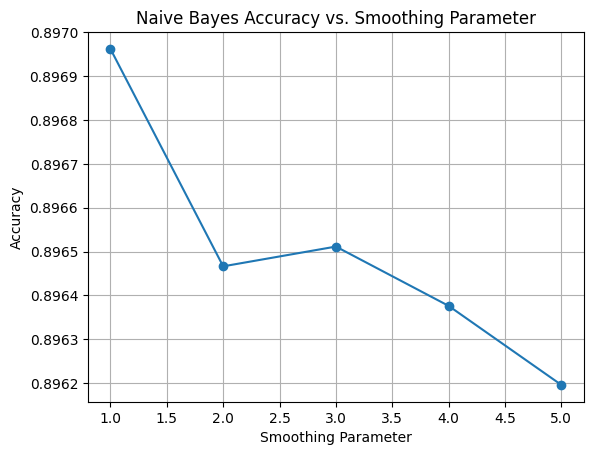

In [ ]:
# Initialize variables to store the best accuracy and corresponding smoothing value
best_accuracy = 0
best_smoothing = 1

# Lists to store smoothing values and their corresponding accuracies
smoothing_values = []
accuracies = []
# Try different smoothing values

for smoothing in [1, 2, 3, 4, 5]:
    model = NaiveBayes(smoothing=smoothing)
    model.train(X_train.values, y_train.values)  # Train the model on the training data
    y_pred = model.predict(X_val.values) # Make predictions on the validation data
    accuracy = accuracy_score(y_val, y_pred) # Calculate accuracy on the validation data


    # Store the smoothing value and accuracy
    smoothing_values.append(smoothing)
    accuracies.append(accuracy)

    if accuracy > best_accuracy:  # Update best accuracy and smoothing if the current model is better
        best_accuracy = accuracy
        best_smoothing = smoothing



print(f"Best Smoothing: {best_smoothing}, Best Accuracy: {best_accuracy:.4f}")

# Evaluate on the test set
model = NaiveBayes(smoothing=best_smoothing) # Create a model with the best smoothing
model.train(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)
y_prob = model.predict_proba(X_test.values)[:, 1]
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot the accuracy vs. smoothing parameter
plt.plot(smoothing_values, accuracies, marker='o')
plt.xlabel('Smoothing Parameter')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Accuracy vs. Smoothing Parameter')
plt.grid(True)
plt.show()

## Confusion Matrix

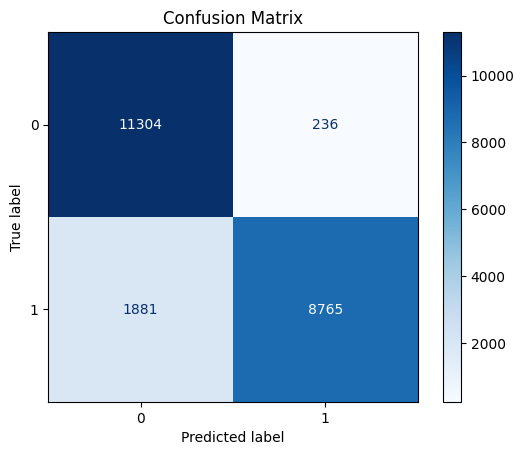

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## ROC curve

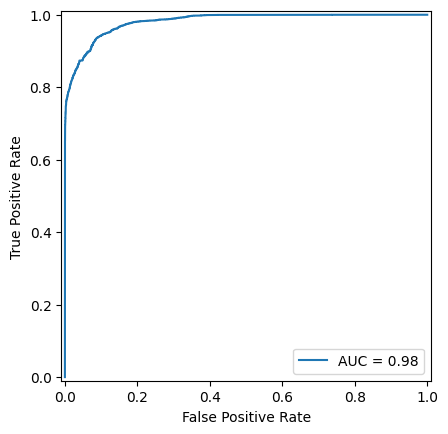

In [ ]:
# calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr) # Calculate the area under the ROC curve (AUC)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc) # Create a ROC curve display object
disp.plot()
plt.show()

## Precision-Recall Curve

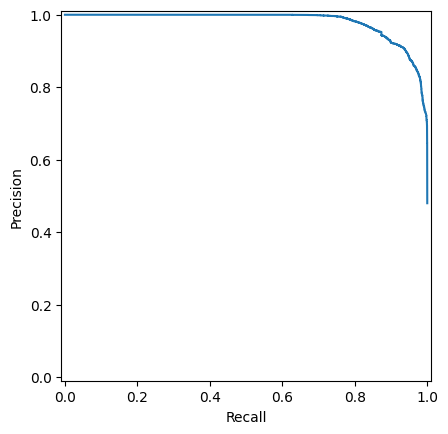

In [ ]:
# Calculate precision and recall values at different thresholds
precision, recall, _ = precision_recall_curve(y_test, y_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall) # Create a Precision-Recall curve display object
disp.plot()
plt.show()

## Classification Report

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)  # Get report as dict
df_report = pd.DataFrame(report).transpose()
display(df_report)

,precision,recall,f1-score,support
0,0.857338,0.979549,0.914378,11540.000000
1,0.973781,0.823314,0.892248,10646.000000
accuracy,0.904579,0.904579,0.904579,0.904579
macro avg,0.915559,0.901432,0.903313,22186.000000
weighted avg,0.913213,0.904579,0.903759,22186.000000
